In [97]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt

import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # filters CUDA and TF logs

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, LSTM

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import shutil

import random

random.seed(42)

In [2]:
# load train and test data 
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [3]:
# convert data for input to CNN model. 
encoder = OneHotEncoder()
X_train_cnn = np.expand_dims(X_train,axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)
y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [4]:
result = pd.concat([y_train, y_test], axis=0)

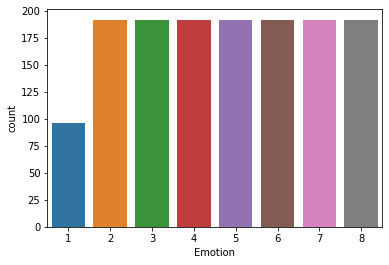

In [5]:
sns.countplot(x ='Emotion', data = result)
plt.show()

## Defining and training model

### Base Model

In [18]:
def base_model_architecture(no_epochs, batch_size, X_train, y_train, X_test, y_test, checkpoint='models/ser_base_model'): 
      
      model = Sequential()
      model.add(Conv1D(16,kernel_size=10,strides=2,activation='relu',input_shape=(X_train.shape[1],1)))
      model.add(BatchNormalization())

      model.add(Conv1D(32,kernel_size=10,strides=2,activation='relu'))
      model.add(BatchNormalization())

      model.add(Flatten())
      model.add(Dense(8,activation='relu'))
      model.add(Dense(8,activation='relu'))
      model.add(Dense(8,activation='softmax'))

      print(model.summary())

    # set callbacks
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                      factor=0.5, patience=4, 
                                                      verbose=1, mode='max', 
                                                      min_lr=0.001)

      early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                      verbose=1)

      model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                            save_weights_only=False,
                                                            monitor='val_accuracy', 
                                                            mode='max', 
                                                            save_best_only=True)

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

      history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=2,
                  use_multiprocessing=False,
                  callbacks = [model_checkpoint, early_stop],
                  validation_data=(X_test, y_test))

      # loading best weights
      model.load_weights(checkpoint)
      
      return history, model

In [20]:
batch_size = 16
history, best_model = base_model_architecture(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 83, 16)            176       
_________________________________________________________________
batch_normalization_6 (Batch (None, 83, 16)            64        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 37, 32)            5152      
_________________________________________________________________
batch_normalization_7 (Batch (None, 37, 32)            128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1184)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 9480      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                

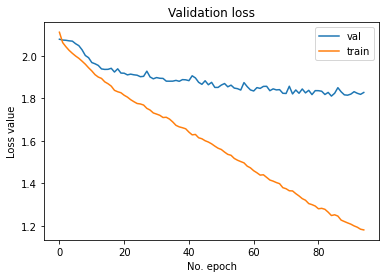

In [21]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Validation loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper right')
plt.show()

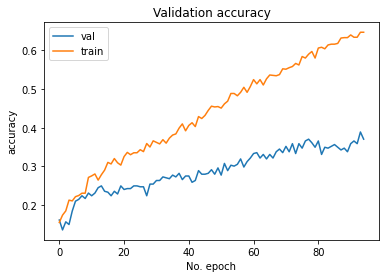

In [22]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

In [23]:
pred_test = best_model.predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)

In [24]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           1       0.20      0.38      0.26        13
           2       0.41      0.44      0.43        63
           3       0.58      0.56      0.57        57
           4       0.38      0.27      0.31        83
           5       0.14      0.80      0.24        10
           6       0.41      0.32      0.36        59
           7       0.53      0.40      0.46        82
           8       0.34      0.32      0.33        65

    accuracy                           0.39       432
   macro avg       0.37      0.44      0.37       432
weighted avg       0.43      0.39      0.40       432



### Experiment model

In [55]:
def experiment_model_architecture(no_epochs, batch_size, X_train, y_train, X_test, y_test, conv_input_dim, no_conv_layers, dense_input_dim, no_dense_layers, lr,checkpoint='models/ser_experiment_models'): 
      
    model = Sequential()

    dropout = 0.2

    for no_layers in range(no_conv_layers):
        
        model.add(Conv1D(conv_input_dim, 10, strides=2, input_shape=(X_train.shape[1],1)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        # model.add(MaxPooling1D(pool_size=(4)))
        # model.add(Dropout(dropout))

        conv_input_dim = conv_input_dim/2
        dropout = 0.2
    
    model.add(Flatten())

    for no_layers in range(no_dense_layers):
        model.add(Dense(dense_input_dim))
        # model.add(Dropout(dropout))
        # if(no_layers==0 and no_dense_layers>1):
        #     model.add(BatchNormalization())
        # dense_input_dim = dense_input_dim/2

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())

    # set callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                    factor=0.5, patience=4, 
                                                    verbose=1, mode='max', 
                                                    min_lr=0.001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                    verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                          save_weights_only=False,
                                                          monitor='val_accuracy', 
                                                          mode='max', 
                                                          save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint, early_stop],
                validation_data=(X_test, y_test))

    # loading best weights
    model.load_weights(checkpoint)
    
    return history, model

Model architectures are defined as follows

* Model 0 -> conv1d(256)→conv1d(128)→conv1d(64)→Dense(128)→Dense(64)→Dense(8)(Softmax)
* Model 1 -> conv1d(256)→conv1d(128)→conv1d(64)→Dense(64)→Dense(8)(Softmax)
* Model 2 -> conv1d(256)→conv1d(128)→Dense(128)→Dense(64)→Dense(8)(Softmax)
* Model 3 -> conv1d(256)→conv1d(128)→Dense(64)→Dense(8)(Softmax)

In [35]:
batch_size = 16
model_input_layers = [[3,2],[3,1],[2,2],[2,1]]
dir_path = './models/ser_experiments_models'
history_models = {}
i = 0
for input_layers in model_input_layers:
    history, best_model = experiment_model_architecture(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,256,input_layers[0],64,input_layers[1],0.0001,checkpoint=dir_path)
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    history_models["Model"+str(i)] = [history,best_model]
    i = i+1


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_4 (Activation)    (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_5 (Activation)    (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 37, 128)           512       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 14, 64)           

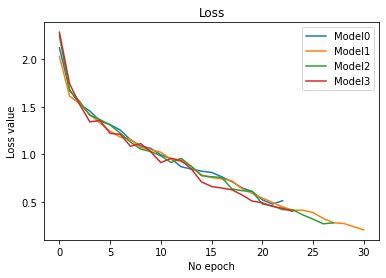

In [36]:
plt.plot(history_models["Model0"][0].history['loss'])
plt.plot(history_models["Model1"][0].history['loss'])
plt.plot(history_models["Model2"][0].history['loss'])
plt.plot(history_models["Model3"][0].history['loss'])
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(['Model0', 'Model1', 'Model2', 'Model3'], loc='upper right')
plt.show()

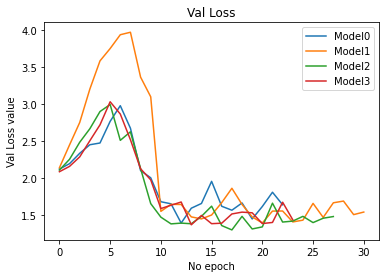

In [37]:
plt.plot(history_models["Model0"][0].history['val_loss'])
plt.plot(history_models["Model1"][0].history['val_loss'])
plt.plot(history_models["Model2"][0].history['val_loss'])
plt.plot(history_models["Model3"][0].history['val_loss'])
plt.title('Val Loss')
plt.ylabel('Val Loss value')
plt.xlabel('No epoch')
plt.legend(['Model0', 'Model1', 'Model2', 'Model3'], loc='upper right')
plt.show()

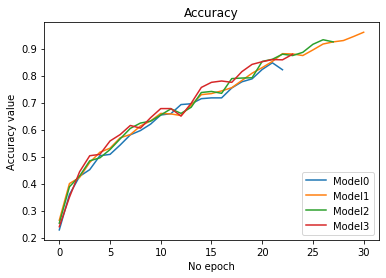

In [38]:
plt.plot(history_models["Model0"][0].history['accuracy'])
plt.plot(history_models["Model1"][0].history['accuracy'])
plt.plot(history_models["Model2"][0].history['accuracy'])
plt.plot(history_models["Model3"][0].history['accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('No epoch')
plt.legend(['Model0', 'Model1', 'Model2', 'Model3'], loc='lower right')
plt.show()

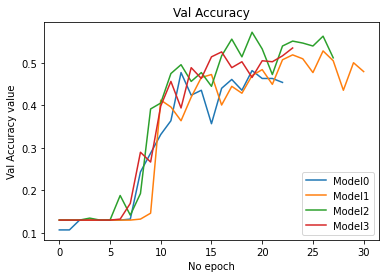

In [40]:
plt.plot(history_models["Model0"][0].history['val_accuracy'])
plt.plot(history_models["Model1"][0].history['val_accuracy'])
plt.plot(history_models["Model2"][0].history['val_accuracy'])
plt.plot(history_models["Model3"][0].history['val_accuracy'])
plt.title('Val Accuracy')
plt.ylabel('Val Accuracy value')
plt.xlabel('No epoch')
plt.legend(['Model0', 'Model1', 'Model2', 'Model3'], loc='lower right')
plt.show()

In [119]:
report_model_arch = {}
for keys in history_models:
    pred_test = history_models[keys][1].predict(X_test_cnn)
    y_pred = encoder.inverse_transform(pred_test)
    y_true = encoder.inverse_transform(y_test_cnn)
    print("----------------------------Prediction for "+str(keys)+"-----------------------------")
    print(classification_report(y_pred,y_true))
    print("------------------------------------------------------------------------------")
    report_model_arch[keys] = classification_report(y_pred,y_true,output_dict=True)

----------------------------Prediction for Model0-----------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.49      0.59      0.53        56
           3       0.44      0.55      0.48        44
           4       0.41      0.41      0.41        58
           5       0.71      0.50      0.59        80
           6       0.54      0.47      0.51        53
           7       0.48      0.48      0.48        63
           8       0.52      0.42      0.46        77

    accuracy                           0.48       432
   macro avg       0.45      0.43      0.43       432
weighted avg       0.52      0.48      0.50       432

------------------------------------------------------------------------------
----------------------------Prediction for Model1-----------------------------
              precision    recall  f1-score   support

           1       0.32      0.21      0.25        38
   

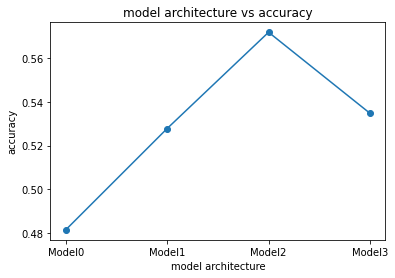

In [123]:
accuracy_model_arch = {}
accuracy_model_arch = []
for keys in report_model_arch:
    accuracy_model_arch.append(report_model_arch[keys]['accuracy'])
plt.title("model architecture vs accuracy")
plt.plot(list(report_model_arch.keys()),accuracy_model_arch,marker='o') 
plt.xlabel("model architecture")
plt.ylabel("accuracy")
plt.show()

### Batch-size Experiments

In [64]:
batch_size = [1,8,16,32,64,128]
model_input_layers = [2,2]
dir_path = './models/ser_experiments_models'
history_models_batch_size = {}
for size in batch_size:
    history, best_model = experiment_model_architecture(150, size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,256,model_input_layers[0],64,model_input_layers[1],0.0001,checkpoint=dir_path)
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    history_models_batch_size[size] = [history,best_model]

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_54 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_55 (Activation)   (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 37, 128)           512       
_________________________________________________________________
flatten_21 (Flatten)         (None, 4736)            

In [102]:
batch_size = [1,8,16,32,64,128]

In [65]:
string_size = [str(size) for size in batch_size]

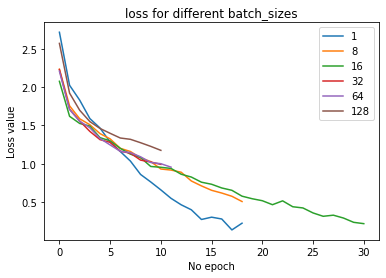

In [66]:
for size in batch_size:
    plt.plot(history_models_batch_size[size][0].history['loss'])
plt.title('loss for different batch_sizes')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(string_size, loc='upper right')
plt.show()

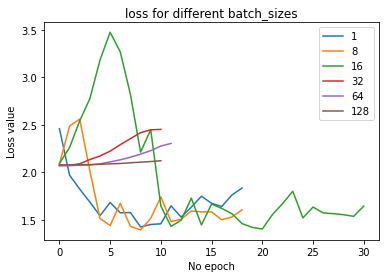

In [67]:
for size in batch_size:
    plt.plot(history_models_batch_size[size][0].history['val_loss'])
plt.title('loss for different batch_sizes')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(string_size, loc='upper right')
plt.show()

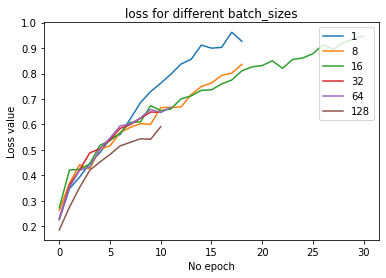

In [68]:
for size in batch_size:
    plt.plot(history_models_batch_size[size][0].history['accuracy'])
plt.title('loss for different batch_sizes')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(string_size, loc='upper right')
plt.show()

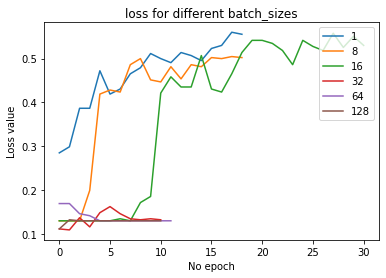

In [69]:
for size in batch_size:
    plt.plot(history_models_batch_size[size][0].history['val_accuracy'])
plt.title('loss for different batch_sizes')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(string_size, loc='upper right')
plt.show()

In [103]:
model_report_batch_size = {}
for size in batch_size:
    pred_test = history_models_batch_size[size][1].predict(X_test_cnn)
    y_pred = encoder.inverse_transform(pred_test)
    y_true = encoder.inverse_transform(y_test_cnn)
    print("----------------------------Prediction for batch size "+str(size)+"-------------------------")
    print(classification_report(y_pred,y_true))
    print("------------------------------------------------------------------------------")
    model_report_batch_size[size] = classification_report(y_pred,y_true,output_dict=True)

----------------------------Prediction for batch size 1-------------------------
              precision    recall  f1-score   support

           1       0.44      0.41      0.42        27
           2       0.65      0.58      0.61        76
           3       0.56      0.47      0.51        66
           4       0.48      0.58      0.53        48
           5       0.54      0.91      0.67        33
           6       0.74      0.52      0.61        65
           7       0.47      0.58      0.52        50
           8       0.56      0.52      0.54        67

    accuracy                           0.56       432
   macro avg       0.56      0.57      0.55       432
weighted avg       0.57      0.56      0.56       432

------------------------------------------------------------------------------
----------------------------Prediction for batch size 8-------------------------
              precision    recall  f1-score   support

           1       0.04      0.14      0.06         7

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

----------------------------Prediction for batch size 64-------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.70      0.17      0.28       223
           6       0.74      0.16      0.27       209
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.17       432
   macro avg       0.18      0.04      0.07       432
weighted avg       0.72      0.17      0.27       432

------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

----------------------------Prediction for batch size 128-------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.13      0.23       431
           6       0.02      1.00      0.04         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.13       432
   macro avg       0.13      0.14      0.03       432
weighted avg       1.00      0.13      0.23       432

------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

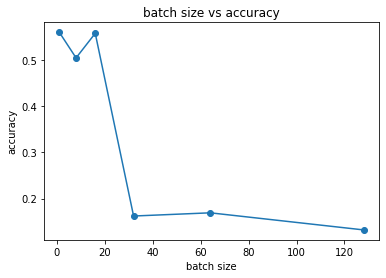

In [117]:
accuracy_batch_size = []
for keys in model_report_batch_size:
    accuracy_batch_size.append(model_report_batch_size[keys]['accuracy'])
plt.title("batch size vs accuracy")
plt.plot(batch_size,accuracy_batch_size,marker='o') 
plt.xlabel("batch size")
plt.ylabel("accuracy")
plt.show()

### Learning rate experiments

In [73]:
lr = [0.01,0.005,0.001,0.0006,0.0001]
model_input_layers = [2,2]
dir_path = './models/ser_experiments_models'
learning_rate_model = {}
batch_size = 16
for lr_rate in lr:
    history, best_model = experiment_model_architecture(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,256,model_input_layers[0],64,model_input_layers[1],lr_rate,checkpoint=dir_path)
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    learning_rate_model[lr_rate] = [history,best_model]


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_78 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_79 (Activation)   (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 37, 128)           512       
_________________________________________________________________
flatten_29 (Flatten)         (None, 4736)            

In [74]:
string_lr = [str(lr_rate) for lr_rate in lr]

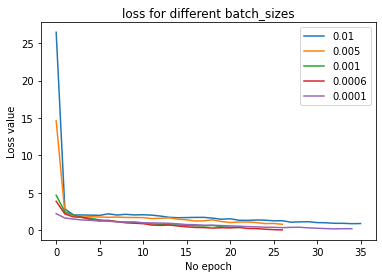

In [75]:
for lr_rate in lr:
    plt.plot(learning_rate_model[lr_rate][0].history['loss'])
plt.title('loss for different batch_sizes')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(string_lr, loc='upper right')
plt.show()

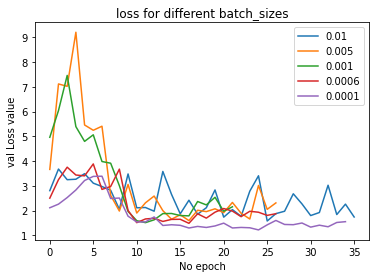

In [76]:
for lr_rate in lr:
    plt.plot(learning_rate_model[lr_rate][0].history['val_loss'])
plt.title('loss for different batch_sizes')
plt.ylabel('val Loss value')
plt.xlabel('No epoch')
plt.legend(string_lr, loc='upper right')
plt.show()

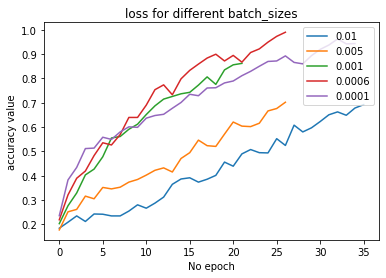

In [77]:
for lr_rate in lr:
    plt.plot(learning_rate_model[lr_rate][0].history['accuracy'])
plt.title('loss for different batch_sizes')
plt.ylabel('accuracy value')
plt.xlabel('No epoch')
plt.legend(string_lr, loc='upper right')
plt.show()

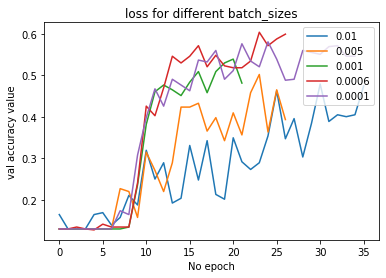

In [78]:
for lr_rate in lr:
    plt.plot(learning_rate_model[lr_rate][0].history['val_accuracy'])
plt.title('loss for different batch_sizes')
plt.ylabel('val accuracy value')
plt.xlabel('No epoch')
plt.legend(string_lr, loc='upper right')
plt.show()

In [100]:
model_report_lr = {}
for lr_rate in lr:
    pred_test = learning_rate_model[lr_rate][1].predict(X_test_cnn)
    y_pred = encoder.inverse_transform(pred_test)
    y_true = encoder.inverse_transform(y_test_cnn)
    print("----------------------------Prediction for learning rate "+str(lr_rate)+"-------------------------")
    print(classification_report(y_pred,y_true))
    print("------------------------------------------------------------------------------")
    model_report_lr[lr_rate] = classification_report(y_pred,y_true,output_dict=True)

----------------------------Prediction for learning rate 0.01-------------------------
              precision    recall  f1-score   support

           1       0.16      0.22      0.19        18
           2       0.79      0.52      0.63       103
           3       0.29      0.55      0.38        29
           4       0.28      0.44      0.34        36
           5       0.57      0.71      0.63        45
           6       0.85      0.33      0.48       117
           7       0.45      0.53      0.49        53
           8       0.29      0.58      0.39        31

    accuracy                           0.48       432
   macro avg       0.46      0.49      0.44       432
weighted avg       0.60      0.48      0.50       432

------------------------------------------------------------------------------
----------------------------Prediction for learning rate 0.005-------------------------
              precision    recall  f1-score   support

           1       0.24      0.23      0

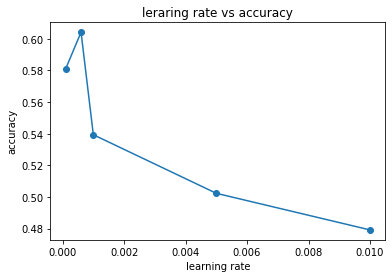

In [116]:
accuracy_lr_rate = []
for lr_value in model_report_lr:
    accuracy_lr_rate.append(model_report_lr[lr_value]['accuracy'])
plt.title("leraring rate vs accuracy")
plt.plot(lr,accuracy_lr_rate,marker='o') 
plt.xlabel("learning rate")
plt.ylabel("accuracy")
plt.show()

### Dropout and Batch-norm layers

In [124]:
def dropout_batch_norm_arch(no_epochs, batch_size, X_train, y_train, X_test, y_test, conv_input_dim, no_conv_layers, dense_input_dim, no_dense_layers, lr,checkpoint='models/ser_experiment_models'): 
      
    model = Sequential()

    dropout = 0.2

    for no_layers in range(no_conv_layers):
        
        model.add(Conv1D(conv_input_dim, 10, strides=2, input_shape=(X_train.shape[1],1)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(4)))
        model.add(Dropout(dropout))

        conv_input_dim = conv_input_dim/2
        dropout = 0.2
    
    model.add(Flatten())

    for no_layers in range(no_dense_layers):
        model.add(Dense(dense_input_dim))
        model.add(Dropout(dropout))
        if(no_layers==0 and no_dense_layers>1):
            model.add(BatchNormalization())

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())

    # set callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                    factor=0.5, patience=4, 
                                                    verbose=1, mode='max', 
                                                    min_lr=0.001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                    verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                          save_weights_only=False,
                                                          monitor='val_accuracy', 
                                                          mode='max', 
                                                          save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint, early_stop],
                validation_data=(X_test, y_test))

    # loading best weights
    model.load_weights(checkpoint)
    
    return history, model

In [125]:
model_input_layers = [2,2]
dir_path = './models/ser_experiments_models'
history, best_model = dropout_batch_norm_arch(150, 16, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,256,model_input_layers[0],64,model_input_layers[1],0.0006,checkpoint=dir_path)
try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))
history_models_batch_norm = [history,best_model]

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_93 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 83, 256)           1024      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 6, 128)            327808    
_________________________________________________________________
activation_94 (Activation)   (None, 6, 128)          

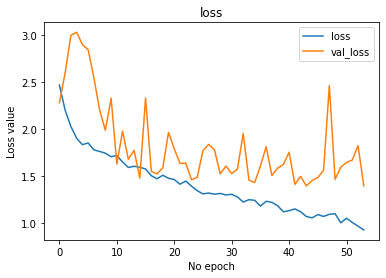

In [126]:
plt.plot(history_models_batch_norm[0].history['loss'])
plt.plot(history_models_batch_norm[0].history['val_loss'])
plt.title('loss')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()

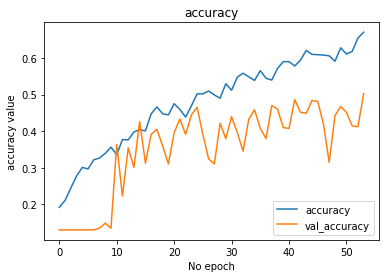

In [128]:
plt.plot(history_models_batch_norm[0].history['accuracy'])
plt.plot(history_models_batch_norm[0].history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No epoch')
plt.legend(['accuracy','val_accuracy'], loc='lower right')
plt.show()

In [130]:
model_report_dropout_batch_norm = []
pred_test = history_models_batch_norm[1].predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)
print("----------------------------Prediction for dropout and batch norm-------------------------")
print(classification_report(y_pred,y_true))
print("------------------------------------------------------------------------------")
model_report_dropout_batch_norm = classification_report(y_pred,y_true,output_dict=True)

----------------------------Prediction for dropout and batch norm-------------------------
              precision    recall  f1-score   support

           1       0.12      0.27      0.17        11
           2       0.69      0.58      0.63        81
           3       0.64      0.38      0.47        93
           4       0.29      0.41      0.34        41
           5       0.80      0.52      0.63        86
           6       0.57      0.57      0.57        46
           7       0.34      0.54      0.42        39
           8       0.37      0.66      0.47        35

    accuracy                           0.50       432
   macro avg       0.48      0.49      0.46       432
weighted avg       0.58      0.50      0.52       432

------------------------------------------------------------------------------


### Final Model

In [131]:
def ser_final(no_epochs, batch_size, X_train, y_train, X_test, y_test, conv_input_dim, no_conv_layers, dense_input_dim, no_dense_layers, lr,checkpoint='models/ser_experiment_models'): 
      
    model = Sequential()

    dropout = 0.2

    for no_layers in range(no_conv_layers):
        
        model.add(Conv1D(conv_input_dim, 10, strides=2, input_shape=(X_train.shape[1],1)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        # model.add(MaxPooling1D(pool_size=(4)))
        # model.add(Dropout(dropout))

        conv_input_dim = conv_input_dim/2
        dropout = 0.2
    
    model.add(Flatten())

    for no_layers in range(no_dense_layers):
        model.add(Dense(dense_input_dim))
        # model.add(Dropout(dropout))
        # if(no_layers==0 and no_dense_layers>1):
        #     model.add(BatchNormalization())
        # dense_input_dim = dense_input_dim/2

    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())

    # set callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                    factor=0.5, patience=4, 
                                                    verbose=1, mode='max', 
                                                    min_lr=0.001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                    verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                          save_weights_only=False,
                                                          monitor='val_accuracy', 
                                                          mode='max', 
                                                          save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint, early_stop],
                validation_data=(X_test, y_test))

    # loading best weights
    model.load_weights(checkpoint)
    
    return history, model

In [136]:
dir_path = './models/ser_final_model'
ser_final_model = []
# history, best_model = cnn_layers(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)
history, best_model = ser_final(150,16,X_train_cnn,y_train_cnn,X_test_cnn,y_test_cnn,256,2,64,2,0.0006,checkpoint=dir_path)
ser_final_model = [history,best_model]

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_99 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_100 (Activation)  (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 37, 128)           512       
_________________________________________________________________
flatten_36 (Flatten)         (None, 4736)            

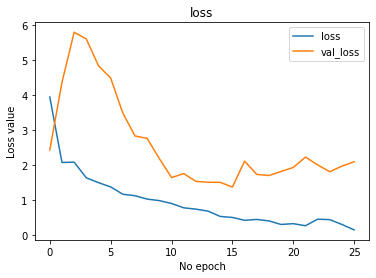

In [137]:
plt.plot(ser_final_model[0].history['loss'])
plt.plot(ser_final_model[0].history['val_loss'])
plt.title('loss')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()

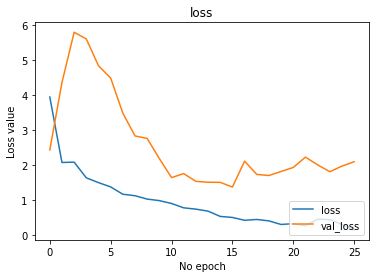

In [138]:
plt.plot(ser_final_model[0].history['loss'])
plt.plot(ser_final_model[0].history['val_loss'])
plt.title('loss')
plt.ylabel('Loss value')
plt.xlabel('No epoch')
plt.legend(['loss','val_loss'], loc='lower right')
plt.show()

In [139]:
final_model_report = []
pred_test = ser_final_model[1].predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)
print("----------------------------Prediction for Final SER model-------------------------")
print(classification_report(y_pred,y_true))
print("------------------------------------------------------------------------------")
final_model_report = classification_report(y_pred,y_true,output_dict=True)

----------------------------Prediction for Final SER model-------------------------
              precision    recall  f1-score   support

           1       0.32      0.35      0.33        23
           2       0.85      0.62      0.72        93
           3       0.44      0.55      0.48        44
           4       0.40      0.66      0.49        35
           5       0.52      0.88      0.65        33
           6       0.72      0.62      0.67        53
           7       0.73      0.50      0.59        90
           8       0.53      0.54      0.54        61

    accuracy                           0.59       432
   macro avg       0.56      0.59      0.56       432
weighted avg       0.63      0.59      0.59       432

------------------------------------------------------------------------------


## Making new predictions

In [140]:
model = keras.models.load_model("models/ser_final_model")
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_99 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_100 (Activation)  (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 37, 128)           512       
_________________________________________________________________
flatten_36 (Flatten)         (None, 4736)            

In [141]:
dummy_feature_input = [list(X_train.loc[0]), list(X_train.loc[1])]  # output format of previous model
model_input = np.expand_dims(dummy_feature_input, axis=2)
model_input

array([[[5.13879661e-01],
        [4.20216500e-01],
        [3.52318310e-01],
        [3.52128765e-01],
        [4.10555228e-01],
        [2.49298959e-01],
        [3.32038850e-01],
        [5.28832254e-01],
        [2.44089480e-01],
        [4.41323976e-01],
        [4.70069313e-01],
        [2.66829587e-01],
        [2.49618022e-01],
        [3.96854861e-01],
        [3.60917658e-01],
        [3.31655576e-01],
        [4.19279684e-01],
        [3.45033404e-01],
        [3.15891851e-01],
        [2.19326411e-01],
        [2.56897994e-01],
        [3.65789160e-01],
        [2.04769100e-01],
        [2.89265888e-01],
        [4.10228502e-01],
        [1.16020585e-01],
        [7.23640742e-01],
        [4.70699569e-01],
        [5.69370298e-01],
        [5.80902369e-01],
        [4.85528610e-01],
        [3.90744057e-01],
        [1.79684575e-01],
        [4.91847265e-01],
        [4.93649178e-01],
        [7.67192377e-01],
        [4.03262273e-01],
        [6.15605219e-01],
        [1.4

In [142]:
preds = model.predict(model_input)
pred_emotions = []
emotion_dict = {1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}
for probs in preds:
    pred = np.argmax(probs)
    pred_emotions.append(pred+1)
print(pred_emotions)
print([emotion_dict[p] for p in pred_emotions])

[6, 4]
['fearful', 'sad']


## Model Architecture

In [143]:
from keras.utils.vis_utils import plot_model

In [144]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 83, 256)           2816      
_________________________________________________________________
activation_99 (Activation)   (None, 83, 256)           0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 83, 256)           1024      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 37, 128)           327808    
_________________________________________________________________
activation_100 (Activation)  (None, 37, 128)           0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 37, 128)           512       
_________________________________________________________________
flatten_36 (Flatten)         (None, 4736)            

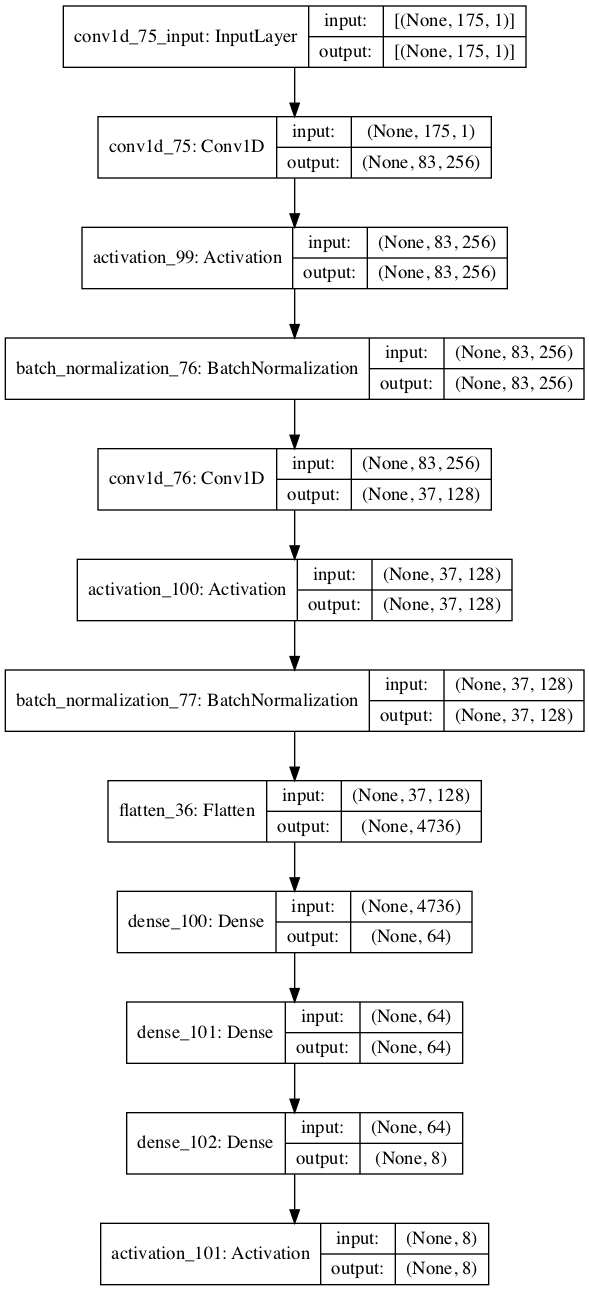

In [145]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)